In [1]:
import sys
sys.path.insert(0, '..\\..\\frxas.py')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, report_fit

from frxas import hdf5_io
from frxas import models
from frxas import visualization

%reload_ext autoreload
%autoreload 2

In [2]:
def chi_direct(x, amp, aoo, Dv, gamma, kappa, yd, f, L, po2, po2_ref):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    ao : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    gamma : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    ao = models.calc_ao(aoo, po2, po2_ref)
    g = gamma
    k = kappa
    L_cm = L * 1e-4 # Convert L to cm
    ts = L_cm **2 / (ao * (10 ** Dv))
    w = 2 * np.pi *f
    
    

    chi = -amp / (ao + ao * g * np.sqrt(2 * 10**k + 1j * w * ts)) \
    * np.exp(-(x + yd) / L * np.sqrt(2 * 10**k + 1j * w * ts))

    return chi

In [2]:
f1 = hdf5_io.get_all_datasets('July18_frXAS') #, start_indices = [[4, 0, 2, 2], [4, 0, 6, 0], [1, 0, 2]])
hdf5_io.close_frxas_file('July18_frXAS')

In [3]:
x, data, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='data_adj')

In [5]:
np.shape(data)

(11,)

In [5]:
colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data))
markers = markers * (len(colors) % len(data))

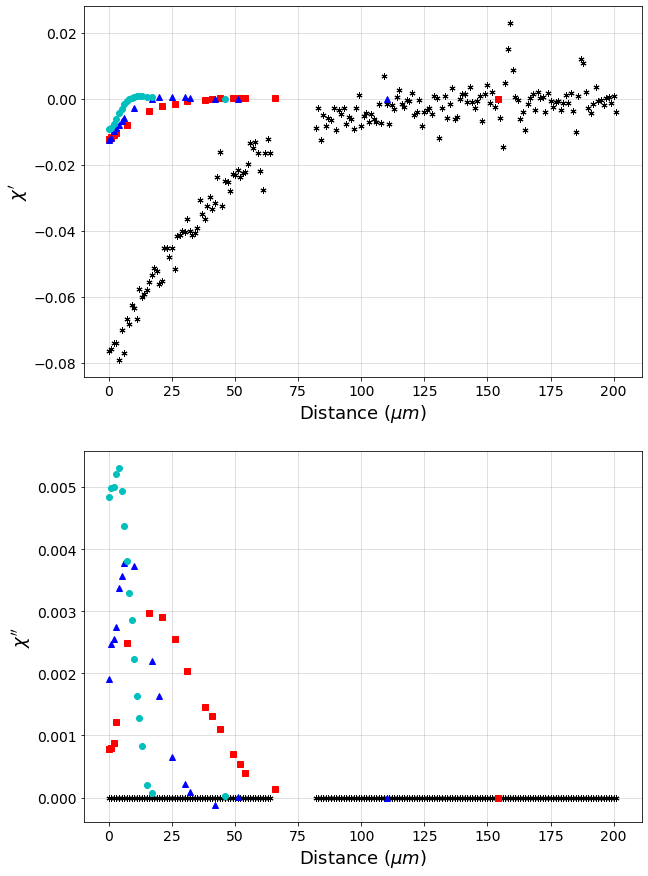

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sizes[0],sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sum(sizes[:2]),sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')

plt.show()

In [15]:
fit_params = Parameters()

for iy, y in enumerate(data):
    fit_params.add('amp_%i' % (iy+1), value=.001, min=0, max=1)
    fit_params.add('aoo_%i' % (iy+1), value=1.5, min=1, max=5)
    fit_params.add('Dv_%i' % (iy+1), value=-5, min=-10, max=-4)
    fit_params.add('gamma_%i' % (iy+1), value=5, min=0, max=100)
    fit_params.add('kappa_%i' % (iy+1), value=-7, min=-8, max=1)
    fit_params.add('yd_%i' % (iy+1), value=0, min=0.0, max=5, vary=True)
    fit_params.add('f_%i' % (iy+1), value=frequencies[iy], vary=False)
    fit_params.add('L_%i' % (iy+1), value=.65, vary=False)
    fit_params.add('po2_%i' % (iy+1), value=gases[iy], vary=False)
    fit_params.add('po2_ref_%i' % (iy+1), value=1, vary=False)

# Setting all aoo to be equal
for iy in np.arange(1, len(data)):
    fit_params['aoo_%i' % (iy+1)].expr = 'aoo_1'

# Setting other parameters within each dataset to be equal
for iy in np.arange(1, sizes[0]):
    fit_params['Dv_%i' % (iy+1)].expr = 'Dv_1'
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_1'
    fit_params['kappa_%i' % (iy+1)].expr = 'kappa_1'

for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
    fit_params['Dv_%i' % (iy+1)].expr = 'Dv_5'
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_5'
    fit_params['kappa_%i' % (iy+1)].expr = 'kappa_5'

for iy in np.arange(sum(sizes[:2])+1, len(data)):
    fit_params['Dv_%i' % (iy+1)].expr = 'Dv_9'
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_9'
    fit_params['kappa_%i' % (iy+1)].expr = 'kappa_9'

In [16]:
for iy in np.arange(2, 4):
#     fit_params['amp_%i' % iy].expr = 'amp_1'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'
    fit_params['Dv_%i' % iy].expr = 'Dv_1'
    fit_params['gamma_%i' % iy].expr = 'gamma_1'
    fit_params['kappa_%i' % iy].expr = 'kappa_1'


for iy in np.arange(5, 7):
#     fit_params['amp_%i' % iy].expr = 'amp_4'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'
    fit_params['Dv_%i' % iy].expr = 'Dv_4'
    fit_params['gamma_%i' % iy].expr = 'gamma_4'
    fit_params['kappa_%i' % iy].expr = 'kappa_4'

for iy in np.arange(8, 9):
#     fit_params['amp_%i' % iy].expr = 'amp_7'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'
    fit_params['Dv_%i' % iy].expr = 'Dv_7'
    fit_params['gamma_%i' % iy].expr = 'gamma_7'
    fit_params['kappa_%i' % iy].expr = 'kappa_7'

In [17]:
mini =lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data, chi_direct), nan_policy='propagate')

In [18]:
out = mini.minimize(method='leastsq')
print(out.redchi)
report_fit(out.params)

8.5193802724045e-06
[[Variables]]
    amp_1:       0.43666342 +/- 1.10796086 (253.73%) (init = 0.001)
    aoo_1:       2.89295337 +/- 9.72782218 (336.26%) (init = 1.5)
    Dv_1:       -6.04829291 +/- 1.16755450 (19.30%) (init = -5)
    gamma_1:     3.25437334 +/- 2.36116424 (72.55%) (init = 5)
    kappa_1:    -3.70531908 +/- 0.01301668 (0.35%) (init = -7)
    yd_1:        3.0531e-15 +/- 0.18394941 (6024978072582096.00%) (init = 0)
    f_1:         0 (fixed)
    L_1:         0.65 (fixed)
    po2_1:       0.01 (fixed)
    po2_ref_1:   1 (fixed)
    amp_2:       0.06009649 +/- 0.15333926 (255.16%) (init = 0.001)
    aoo_2:       2.89295337 +/- 9.72884261 (336.29%) == 'aoo_1'
    Dv_2:       -6.04829291 +/- 1.16534459 (19.27%) == 'Dv_1'
    gamma_2:     3.25437334 +/- 2.36104379 (72.55%) == 'gamma_1'
    kappa_2:    -3.70531908 +/- 0.06661307 (1.80%) == 'kappa_1'
    yd_2:        0.00000000 +/- 0.25337749 (inf%) (init = 0)
    f_2:         0.25 (fixed)
    L_2:         0.65 (fixed)
    po2

C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\printfuncs.py:177: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\printfuncs.py:177: RuntimeWarning: divide by zero encountered in double_scalars


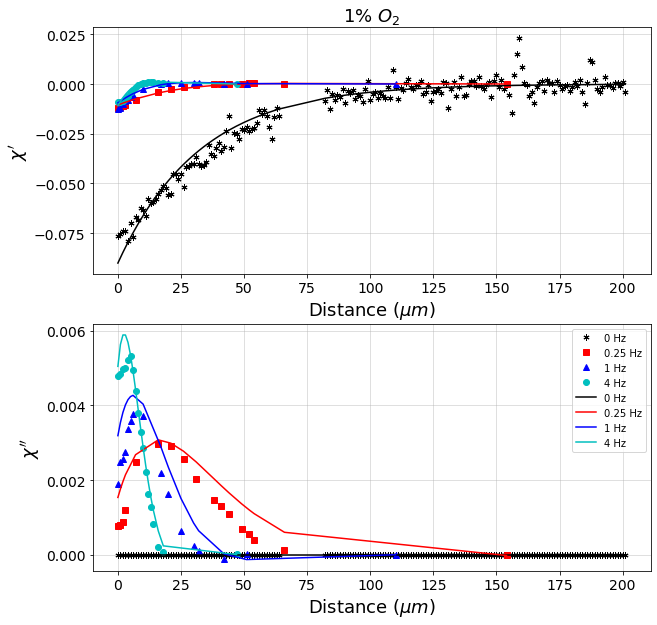

In [12]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label=str(frequencies[iy]) + ' Hz')
for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_direct),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz')
    
axes[0].set_title('1% $O_2$', fontsize=18)
plt.legend()
plt.show()
# plt.savefig(r'Plots\Pattern_Model_Amp_yd_1%O2.png', dpi=300, bbox_inches='tight')

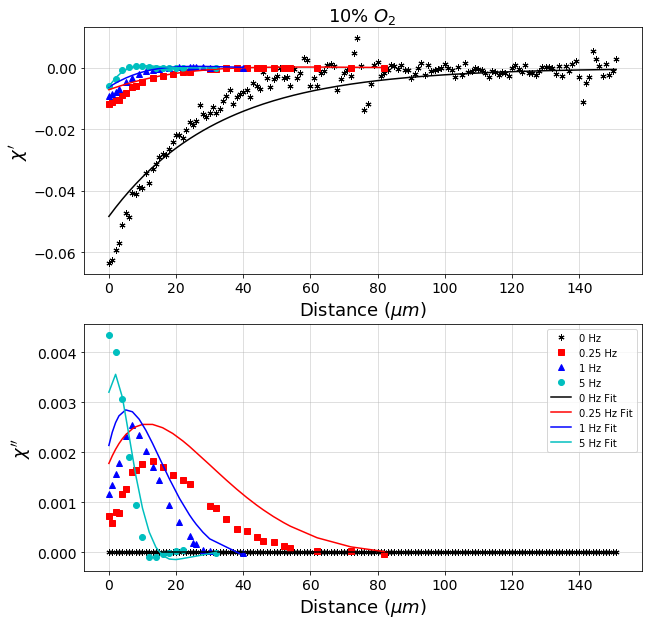

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(sizes[0],sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label=str(frequencies[iy]) + ' Hz')

for iy in np.arange(sizes[0],sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_direct),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.legend()
plt.show()

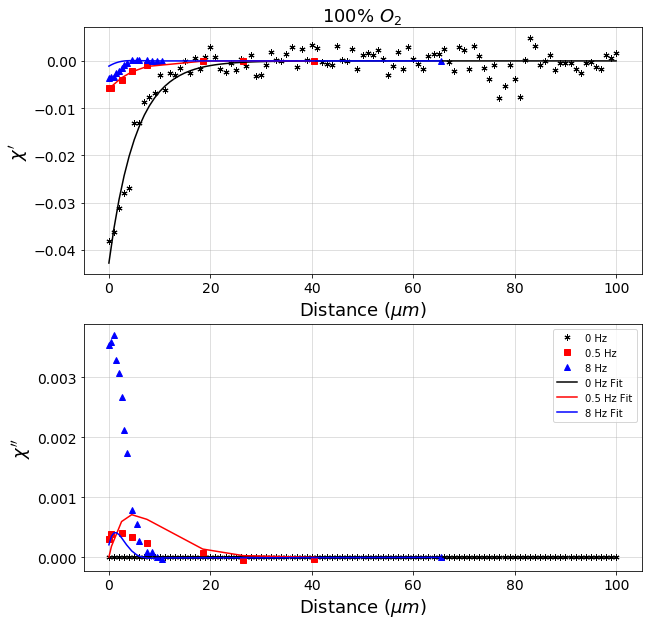

In [141]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(sum(sizes[:2]),sum(sizes)):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='', 
                           label=str(frequencies[iy]) + ' Hz')
for iy in np.arange(sum(sizes[:2]),sum(sizes)):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_direct),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('100% $O_2$', fontsize=18)
plt.legend()
plt.show()